<a href="https://colab.research.google.com/github/dojian/mental_health_chatbot/blob/dongjian/An_Jian_with_generated_data_gretel_ml_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.utils import resample
from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
# Read the datasets
processed = pd.read_json('https://gretel-public-website.s3.amazonaws.com/datasets/evaluation/processed-data.json', lines=True)
unprocessed = pd.read_json('https://gretel-public-website.s3.amazonaws.com/datasets/evaluation/unprocessed-data.json', lines=True)

In [ ]:
# Print the example processed data
processed

,topic,question,excerpt
0,android,Why live wallpapers use phone call info,"When I install any live wallpaper, I am shown ..."
1,scifi,Where is this missing part to the Tron: Legacy...,I finally bought the Tron: Legacy Original Sou...
2,scifi,Was the tracking bug actually inserted into Ne...,"When Neo is detained by the Agents, they place..."
3,electronics,Are there strong but insulative screws?,Common through-hole power semiconductor device...
4,scifi,Guys with a “boomstick”,"Here's a tough one, I'm looking for a novel in..."
...,...,...,...
12126,security,Is it safer to compile open source code vs sim...,"I understand that with OpenSource software, my..."
12127,scifi,Is 'The Night The Sky Cried Tears Of Fire' by ...,So there's this music album 'Warp Riders' by a...
12128,wordpress,Multiple Archive Pages for Custom Post Types A...,"This is both a ""how do I?"" and ""how should I?""..."
12129,gis,Trouble storing an IMap with ArcObjects 10 and...,I'm storing a reference to an IMap in a custom...


In [ ]:
# Check the processed topics
topics = processed.value_counts('topic')
topics

,count
topic,
scifi,1393
gis,1382
android,1357
apple,1250
electronics,1240
unix,1209
wordpress,1198
photo,1152
security,1121


In [ ]:
# Print the example unprocessed data
unprocessed

,question,excerpt
0,AJAX - Returning Two JSON Objects with One PHP...,How would I go about returning two JSON object...
1,Custom highlighting for gtksourceview not working,I am trying to write my own syntax highlightin...
2,plugin class inheritance. cannot change variable,I guess I have a problem understanding inherit...
3,Is there a max limit for objects per process? ...,"In C++, map class is very comfortable. Instead..."
4,How to change BarChart labels font?,"The question seems trivial, but no sign of suc..."
...,...,...
8083,"Two power sources, common ground and noise",I'm having the following circuit:\n\n\nWhere T...
8084,Applescript failing even though variables are ...,I have a file that is a list of numbers like s...
8085,Why list of array not plotting? [closed],I have an array just evaluated to be \n\nInpu...
8086,Multiple User Accounts with 1 email address on...,I recently found the following post dealing wi...


1. Check the data

In [ ]:
# Check for duplicate rows based on all columns
duplicates = processed.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
processed = processed.drop_duplicates()
print(f"Data after removing duplicates: {processed.shape}")


Number of duplicate rows: 4
Data after removing duplicates: (12127, 3)


In [ ]:
# Check for missing values in each column
missing_values = processed.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
topic       0
question    0
excerpt     0
dtype: int64


2. Split the train and validation set

In [ ]:
# Original split (before adding synthetic data)
train_data, val_data = train_test_split(
    processed,
    test_size=0.2,  # 20% validation set
    random_state=42,
    stratify=processed['topic']
)

In [ ]:
train_data.value_counts('topic')

,count
topic,
scifi,1114
gis,1105
android,1085
apple,1000
electronics,992
unix,967
wordpress,958
photo,922
security,897


In [ ]:
train_data.value_counts('topic')-1114

,count
topic,
scifi,0
gis,-9
android,-29
apple,-114
electronics,-122
unix,-147
wordpress,-156
photo,-192
security,-217


So we generated these amount of examples using Gretel; details in Notebook Generate_Gretel, and saved the results in "generated_data_with_topics.csv"

3. Oversampling the minority class with Gretel generated data in train_data and call it balanced_df

In [ ]:
train_data

,topic,question,excerpt
2359,photo,"Is “Active D-Lighting, NR” a necessary evil?","Are the settings ""Active D-Lighting, NR"" in Ni..."
7542,apple,Mountain Lion unable to start forbidden sign H...,"so I have a MacBook Pro 17"" with the newest Mo..."
2742,gis,Rendering geoJson polygons in google maps andr...,I'm in the process of publishing spatial data ...
668,unix,How to tell Chromium-browser to run a url as s...,I have a web application which crawls data and...
6200,photo,What's the difference between taking long expo...,What's the difference between long exposure wh...
...,...,...,...
8455,wordpress,"wp_editor not saving data, and text area showi...","This is my custom meta box, here text area sho..."
11306,unix,Running script on system start as given user,I have a small script on a dev/staging server ...
8575,android,How do I get my GPS working in Android 4.1 Jel...,Recently I've been having all sorts of trouble...
11920,mathematica,Sensitivity Analysis: Global Sensitivity and S...,I have a model which accepts several input par...


In [ ]:
synthetic_data = pd.read_csv('generated_data_with_topics.csv')
synthetic_data

,topic,Question,Excerpt
0,gis,How to create a custom shapefile (.shp) in Pyt...,I have been using ArcGIS Desktop and would lik...
1,gis,How to create a grid from a set of points?,How can I create a grid from a set of points i...
2,gis,How to create a new raster layer from an exist...,I have a raster layer in ArcGIS 9.2. It's a sa...
3,gis,Calculate the distance from a point to a line,"This question is related to this one,..."
4,gis,How to create a custom legend for a raster map...,I have a raster map of a flood zone in ArcGIS....
...,...,...,...
1434,mathematica,Finding a solution to a differential equation,I have a differential equation that I'd like t...
1435,mathematica,What is the best way to solve a linear equatio...,I have the following equation:\n\nx+y+z = 1\n\...
1436,mathematica,How to calculate the integral $\int_0^1\frac{\...,I have tried to calculate the integral $\int_0^
1437,mathematica,How to get the derivative of a list of equations,I have a list of equations in the form y[i] = ...


In [ ]:
# Check for missing values in each column
missing_values = synthetic_data.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
topic        0
Question     0
Excerpt     34
dtype: int64


In [ ]:
# Remove missing_values rows
synthetic_data = synthetic_data.dropna()
print(f"Data after removing duplicates: {synthetic_data.shape}")

Data after removing duplicates: (1405, 3)


In [ ]:
duplicates = synthetic_data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [ ]:
# Add synthetic data to the training set
synthetic_data.rename(columns={"Question": "question", "Excerpt": "excerpt"}, inplace=True)
balanced_df = pd.concat([train_data, synthetic_data], ignore_index=True)
balanced_df

<ipython-input-33-9d808a892908>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthetic_data.rename(columns={"Question": "question", "Excerpt": "excerpt"}, inplace=True)


,topic,question,excerpt
0,photo,"Is “Active D-Lighting, NR” a necessary evil?","Are the settings ""Active D-Lighting, NR"" in Ni..."
1,apple,Mountain Lion unable to start forbidden sign H...,"so I have a MacBook Pro 17"" with the newest Mo..."
2,gis,Rendering geoJson polygons in google maps andr...,I'm in the process of publishing spatial data ...
3,unix,How to tell Chromium-browser to run a url as s...,I have a web application which crawls data and...
4,photo,What's the difference between taking long expo...,What's the difference between long exposure wh...
...,...,...,...
11101,mathematica,Finding a solution to a differential equation,I have a differential equation that I'd like t...
11102,mathematica,What is the best way to solve a linear equatio...,I have the following equation:\n\nx+y+z = 1\n\...
11103,mathematica,How to calculate the integral $\int_0^1\frac{\...,I have tried to calculate the integral $\int_0^
11104,mathematica,How to get the derivative of a list of equations,I have a list of equations in the form y[i] = ...


In [ ]:
#check the distribution
balanced_df.value_counts('topic')

,count
topic,
android,1114
gis,1114
scifi,1114
apple,1113
electronics,1113
photo,1112
security,1112
unix,1110
wordpress,1110


In [ ]:
# Create a mapping from topics to integers
unique_topics = processed['topic'].unique()
label_mapping = {topic: idx for idx, topic in enumerate(unique_topics)}
label_mapping

{'android': 0,
 'scifi': 1,
 'electronics': 2,
 'gis': 3,
 'apple': 4,
 'photo': 5,
 'security': 6,
 'wordpress': 7,
 'unix': 8,
 'mathematica': 9}

In [ ]:
# Apply the mapping to the train dataset
balanced_df['label'] = balanced_df['topic'].map(label_mapping)
balanced_df

,topic,question,excerpt,label
0,photo,"Is “Active D-Lighting, NR” a necessary evil?","Are the settings ""Active D-Lighting, NR"" in Ni...",5
1,apple,Mountain Lion unable to start forbidden sign H...,"so I have a MacBook Pro 17"" with the newest Mo...",4
2,gis,Rendering geoJson polygons in google maps andr...,I'm in the process of publishing spatial data ...,3
3,unix,How to tell Chromium-browser to run a url as s...,I have a web application which crawls data and...,8
4,photo,What's the difference between taking long expo...,What's the difference between long exposure wh...,5
...,...,...,...,...
11101,mathematica,Finding a solution to a differential equation,I have a differential equation that I'd like t...,9
11102,mathematica,What is the best way to solve a linear equatio...,I have the following equation:\n\nx+y+z = 1\n\...,9
11103,mathematica,How to calculate the integral $\int_0^1\frac{\...,I have tried to calculate the integral $\int_0^,9
11104,mathematica,How to get the derivative of a list of equations,I have a list of equations in the form y[i] = ...,9


In [ ]:
# Apply the mapping to the validation dataset
val_data['label'] = val_data['topic'].map(label_mapping)
val_data

,topic,question,excerpt,label
3949,scifi,How many times has Abeloth escaped?,I have just finished reading Fate of the Jedi:...,1
6775,scifi,How does a Dyson Sphere's inhabitants deal wit...,It's well known that because the gravitational...,1
4772,apple,Weird colors on secondary monitor,When I connect my macbook air (2012 early I th...,4
10562,electronics,Ten millions cycles on arduino,I am trying to build a suitable pull-switch fo...,2
2238,security,Hardware Level Write Protection for a CD-R,Let's say you burn a CD-R and it is finalized....,6
...,...,...,...,...
7673,mathematica,Subset of edges with a different color,I want to color a subset of the edges of my gr...,9
5176,electronics,AC coupling with,I've the following amplifier circuit:\n\n\n\nT...,2
5519,photo,How can I make an AC adaptor for a Fujifilm S2...,I bought a Fujifilm Finepix S2980. As the AC p...,5
9626,security,Can hackers find secret tokens passed to HTTP ...,I have some code like this in index.php:\n\nif...,6


In [ ]:
#Convert to dictionary
# Train set:
train_set =balanced_df.to_dict(orient='records')
# Validation set:
val_set = val_data.to_dict(orient='records')

train_set[0]

{'topic': 'photo',
 'question': 'Is “Active D-Lighting, NR” a necessary evil?',
 'excerpt': 'Are the settings "Active D-Lighting, NR" in Nikon DSLR necessary evil or should this be turned off (managed through image editor)? What is the effect of this setting on processing time and battery ...',
 'label': 5}

In [ ]:
val_set[0]

{'topic': 'scifi',
 'question': 'How many times has Abeloth escaped?',
 'excerpt': "I have just finished reading Fate of the Jedi: Apocalypse. I remember the part where the Jedi team reviewed the Killik's art and learned of Abeloth, the Bringer of Chaos. Apparently the art revealed ...",
 'label': 1}

4. Device Setup and Tokenizer Initialization

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from transformers import AutoTokenizer,DebertaModel

deberta_model = DebertaModel.from_pretrained("microsoft/deberta-base").to(device)

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

In [ ]:
#test one exmaple to make sure it is loaded and check hidden size
toy_inputs = tokenizer("This is new", return_tensors="pt").to(device)
toy_outputs = deberta_model(**toy_inputs)

last_hidden_states = toy_outputs.last_hidden_state

last_hidden_states.shape

torch.Size([1, 5, 768])

In [ ]:
#Set up dataloader
class DebertaClassificationData(Dataset):
    def __init__(self, base_data, tokenizer, max_len):
        self.data = base_data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        question = item['question']
        excerpt = item['excerpt']
        combined_text = question + " [SEP] " + excerpt
        label = item['label']  # Numeric label

        tokenized_example = self.tokenizer(
            combined_text,
            return_tensors="pt",
            max_length=self.max_len,
            truncation=True,
            padding='max_length'
        )

        return {
            'input_ids': tokenized_example['input_ids'].squeeze(0),
            'attention_mask': tokenized_example['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long),
            'question': question,  # Include original question
            'excerpt': excerpt     # Include original excerpt
        }

# Create datasets and dataloaders
max_len = 100
batch_size = 4

deberta_train_data = DebertaClassificationData(train_set, tokenizer, max_len)
deberta_test_data = DebertaClassificationData(val_set, tokenizer, max_len)

deberta_train_loader = DataLoader(deberta_train_data, batch_size=batch_size, shuffle=True)
deberta_test_loader = DataLoader(deberta_test_data, batch_size=batch_size, shuffle=True)


In [ ]:
deberta_train_data[0]

{'input_ids': tensor([    1,  6209,    44,    48, 42586,   211,    12, 31091,   154,     6,
         17731,    17,    46,    10,  2139,  9247,   116,  1437,     2,  3945,
             5,  9629,    22, 42586,   211,    12, 31091,   154,     6, 17731,
           113,    11, 29850, 35409,   500,  2139,  9247,    50,   197,    42,
            28,  1224,   160,    36, 28770,   149,  2274,  4474, 26610,   653,
            16,     5,  1683,     9,    42,  2749,    15,  5774,    86,     8,
          3822,  1666,     2,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 

5. Model Definition

In [ ]:
#Model
class DebertaClassificationNetwork(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.deberta = deberta_model
        self.linear = torch.nn.Linear(768, num_classes)  # DeBERTa hidden size is 768

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token output
        logits = self.linear(cls_output)
        return logits

# Initialize model
num_classes = len(processed['topic'].unique())
deberta_classification_model = DebertaClassificationNetwork(num_classes).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
adam_optimizer_deberta = torch.optim.AdamW(deberta_classification_model.parameters(), lr=0.00001)

6. Train and test loop

In [ ]:
def deberta_train_loop(dataloader, model, loss_fn, optimizer, reporting_interval=100, steps=None):
    """
    Training loop for DeBerta classification models.
    Args:
    - dataloader: DataLoader for the training set.
    - model: DeBerta classification model.
    - loss_fn: Loss function for training.
    - optimizer: Optimizer for training.
    - reporting_interval: Print metrics every `reporting_interval` batches.
    - steps: Number of batches to process
    """
    model.train()  # Set model to training mode
    epoch_loss, batch = 0, 0

    for batch_num, data in enumerate(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['label'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch += 1

        if (batch_num + 1) % reporting_interval == 0:
            print(f"batch_num {batch_num+1}: Avg Loss = {epoch_loss / batch:.4f}")

        if steps is not None and batch_num +1 >= steps:
            break

    print(f"Training Results: \n  Avg train loss: {epoch_loss/batch:>8f} \n")



def deberta_test_loop(dataloader, model, loss_fn, reporting_interval=100,steps=None):
    """
    Testing loop for DeBERTa-based classification model.
    Reports accuracy and average loss after the specified reporting interval.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss, correct, total = 0, 0, 0
    true_labels, predicted_labels = [], []
    questions, excerpts = [], []  # Collect questions and excerpts for analysis

    with torch.no_grad():  # Disable gradient calculation
        for batch_num, data in enumerate(dataloader):
          input_ids = data['input_ids'].to(device)
          attention_mask = data['attention_mask'].to(device)
          targets = data['label'].to(device)

          # Forward pass
          outputs = model(input_ids, attention_mask)

          # Calculate loss
          loss = loss_fn(outputs, targets)
          test_loss += loss.item()

          # Calculate accuracy
          predicted = torch.argmax(outputs, dim=1)
          true_labels.extend(targets.cpu().numpy())  # Store true labels
          predicted_labels.extend(predicted.cpu().numpy())  # Store predicted labels

          # Collect raw data for analysis
          questions.extend(data['question'])  # Original question
          excerpts.extend(data['excerpt'])    # Original excerpt

          # Accuracy
          correct += (predicted == targets).sum().item()
          total += targets.size(0)

          batch = batch_num + 1

          if (batch) % reporting_interval == 0:
            current_accuracy = 100 * correct / total
            print(f"Batch {batch}: Current Accuracy = {current_accuracy:.2f}%")

          if steps is not None and batch >= steps:
            break

    correct = float(correct)

    test_loss /= batch
    correct /= total

    print(f"Test Results: \n Test Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>8f} \n")
    # Return true and predicted labels for further analysis
    return true_labels, predicted_labels, questions, excerpts

6. Training and validation using processed data

In [ ]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # Training
    deberta_train_loop(deberta_train_loader , deberta_classification_model, loss_fn, adam_optimizer_deberta, steps=2777)

    # Testing(Validation)
    true_labels, predicted_labels, questions, excerpts = deberta_test_loop(deberta_test_loader , deberta_classification_model, loss_fn, steps=607)

print("Done!")


Epoch 1
-------------------------------
batch_num 100: Avg Loss = 2.2466
batch_num 200: Avg Loss = 1.5854
batch_num 300: Avg Loss = 1.2453
batch_num 400: Avg Loss = 1.0610
batch_num 500: Avg Loss = 0.9446
batch_num 600: Avg Loss = 0.8492
batch_num 700: Avg Loss = 0.7855
batch_num 800: Avg Loss = 0.7348
batch_num 900: Avg Loss = 0.6926
batch_num 1000: Avg Loss = 0.6703
batch_num 1100: Avg Loss = 0.6286
batch_num 1200: Avg Loss = 0.6019
batch_num 1300: Avg Loss = 0.5823
batch_num 1400: Avg Loss = 0.5653
batch_num 1500: Avg Loss = 0.5497
batch_num 1600: Avg Loss = 0.5316
batch_num 1700: Avg Loss = 0.5209
batch_num 1800: Avg Loss = 0.5091
batch_num 1900: Avg Loss = 0.4995
batch_num 2000: Avg Loss = 0.4924
batch_num 2100: Avg Loss = 0.4826
batch_num 2200: Avg Loss = 0.4713
batch_num 2300: Avg Loss = 0.4644
batch_num 2400: Avg Loss = 0.4581
batch_num 2500: Avg Loss = 0.4514
batch_num 2600: Avg Loss = 0.4448
batch_num 2700: Avg Loss = 0.4404
Training Results: 
  Avg train loss: 0.439361 

Bat

Confusion matrix

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix_normalized = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)  # Row normalization

class_labels = list(label_mapping.keys())
class_labels

['android',
 'scifi',
 'electronics',
 'gis',
 'apple',
 'photo',
 'security',
 'wordpress',
 'unix',
 'mathematica']

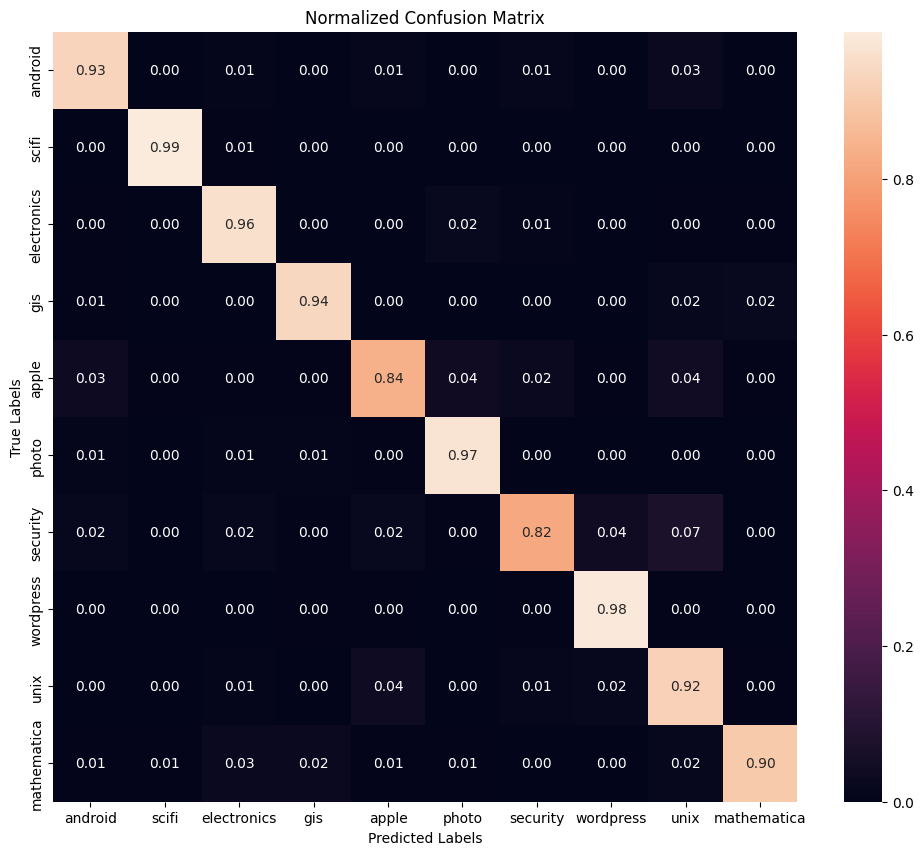

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_normalized,
    annot=True,
    #cmap="coolwarm",
    xticklabels=class_labels,
    yticklabels=class_labels,
    fmt=".2f"
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

              precision    recall  f1-score   support

     android       0.93      0.93      0.93       272
       scifi       0.99      0.99      0.99       279
 electronics       0.92      0.96      0.94       248
         gis       0.97      0.94      0.95       277
       apple       0.91      0.84      0.87       250
       photo       0.92      0.97      0.94       230
    security       0.92      0.82      0.87       224
   wordpress       0.94      0.98      0.96       239
        unix       0.83      0.92      0.87       242
 mathematica       0.94      0.90      0.92       165

    accuracy                           0.93      2426
   macro avg       0.93      0.93      0.93      2426
weighted avg       0.93      0.93      0.93      2426



In [ ]:
# Create an inverse mapping from numeric labels to topics
label_mapping_inverse = {value: key for key, value in label_mapping.items()}

# Create a DataFrame for analysis
data_analysis = pd.DataFrame({
    'Question': questions,
    'Excerpt': excerpts,
    'True Label': [label_mapping_inverse[label] for label in true_labels],  # Map numeric labels back to topics
    'Predicted Label': [label_mapping_inverse[label] for label in predicted_labels]
})

# Filter misclassified examples
misclassified = data_analysis[data_analysis['True Label'] != data_analysis['Predicted Label']]

# Save misclassified examples for further inspection
misclassified.to_csv('misclassified_examples.csv', index=False)

# Display some misclassified examples
print(misclassified.head())


                                             Question  \
22        UART0 Access in AM1808 using Embedded Linux   
29  trying to reset security questions but the “ F...   
34     Calculator with phone keypad question [closed]   
45  ALERT - ASCII-NUL chars not allowed within req...   
72  Selecting rows in a CSV file based on column v...   

                                              Excerpt   True Label  \
22  I am trying to interface GSM module with my AM...         unix   
29  I have forgotton my security answers and are t...        apple   
34  I am not an electronic person and found this s...  electronics   
45  In a Drupal site, I get this error in my Debia...     security   
72  I have a CSV file with 4 columns: Itemname,Val...         unix   

   Predicted Label  
22     electronics  
29        security  
34         android  
45            unix  
72       wordpress  


In [ ]:
misclassified[misclassified['True Label'] =='apple'].head()

,Question,Excerpt,True Label,Predicted Label
29,trying to reset security questions but the “ F...,I have forgotton my security answers and are t...,apple,security
77,Where does Install.app cache files,I am writing some test for our pkg installer. ...,apple,unix
180,"Apache VirtualDocumentRoot, MAMP, .local domai...",I have a problem making xip.io works. I have s...,apple,unix
307,How to change a users name on a Shared Photost...,Shared Photostreams are a fantastic way to kee...,apple,photo
424,How to save or export a photo without the GPS ...,I have used Preview's export function to expor...,apple,photo


In [ ]:
torch.save(deberta_classification_model.state_dict(), "deberta_model_with_synthetic_data.pth")

In [ ]:
from google.colab import files
files.download('/content/deberta_model_with_synthetic_data.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7. Predict on unlabeled data

In [ ]:
#Only reload the model if restart the notebook that the trained model is missing
# Ensure the model architecture matches when loading
"""
from transformers import AutoTokenizer,DebertaModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deberta_model = DebertaModel.from_pretrained("microsoft/deberta-base").to(device)
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

class DebertaClassificationNetwork(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.deberta = deberta_model
        self.linear = torch.nn.Linear(768, num_classes)  # DeBERTa hidden size is 768

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token output
        logits = self.linear(cls_output)
        return logits
num_classes=10
deberta_classification_model = DebertaClassificationNetwork(num_classes).to(device)
deberta_classification_model.load_state_dict(torch.load("deberta_model_with_synthetic_data.pth"))
deberta_classification_model.eval()  # Set the model to evaluation mode
"""

In [ ]:
class UnprocessedDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data.iloc[index]
        question = item['question']
        excerpt = item['excerpt']
        combined_text = question + " [SEP] " + excerpt
        tokenized_example = self.tokenizer(
            combined_text,
            return_tensors="pt",
            max_length=self.max_len,
            truncation=True,
            padding='max_length'
        )
        return {
            'input_ids': tokenized_example['input_ids'].squeeze(0),
            'attention_mask': tokenized_example['attention_mask'].squeeze(0),
            'question': question,  # Keep the original question for later use
            'excerpt': excerpt     # Keep the original excerpt for later use
        }


In [ ]:
unprocessed_dataset = UnprocessedDataset(unprocessed, tokenizer, max_len=100)
unprocessed_loader = DataLoader(unprocessed_dataset, batch_size=16, shuffle=False)

In [ ]:
def predict_topics(dataloader, model):
    model.eval()
    predictions = []
    questions = []
    excerpts = []
    embeddings = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

            # Extract the [CLS] token embeddings from the DeBERTa encoder
            encoder_outputs = model.deberta(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = encoder_outputs.last_hidden_state[:, 0, :].cpu().numpy()

            # Collect predictions, metadata and embeddings
            predictions.extend(predicted_labels)
            embeddings.extend(cls_embeddings)
            questions.extend(batch['question'])  # Keep original questions
            excerpts.extend(batch['excerpt'])    # Keep original excerpts

    return predictions, questions, excerpts, np.array(embeddings)


In [ ]:
# Get predictions and original data
predicted_labels, questions, excerpts, embeddings = predict_topics(unprocessed_loader, deberta_classification_model)

# Map predictions back to topic names
label_mapping_inverse = {value: key for key, value in label_mapping.items()}
predicted_topics = [label_mapping_inverse[label] for label in predicted_labels]

# Create a DataFrame for output
output_data = pd.DataFrame({
    'topic': predicted_topics,
    'question': questions,
    'excerpt': excerpts
})

# Save to JSON
output_data.to_json("categorized_documents.json", orient="records", lines=True)


In [ ]:
output_data

,topic,question,excerpt
0,wordpress,AJAX - Returning Two JSON Objects with One PHP...,How would I go about returning two JSON object...
1,apple,Custom highlighting for gtksourceview not working,I am trying to write my own syntax highlightin...
2,wordpress,plugin class inheritance. cannot change variable,I guess I have a problem understanding inherit...
3,gis,Is there a max limit for objects per process? ...,"In C++, map class is very comfortable. Instead..."
4,mathematica,How to change BarChart labels font?,"The question seems trivial, but no sign of suc..."
...,...,...,...
8083,electronics,"Two power sources, common ground and noise",I'm having the following circuit:\n\n\nWhere T...
8084,apple,Applescript failing even though variables are ...,I have a file that is a list of numbers like s...
8085,mathematica,Why list of array not plotting? [closed],I have an array just evaluated to be \n\nInpu...
8086,wordpress,Multiple User Accounts with 1 email address on...,I recently found the following post dealing wi...


8. Visualize predicted labels

In [ ]:
# Reduce dimensions using t-SNE
def reduce_dimensions(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    return reduced_embeddings

# Apply dimensionality reduction
reduced_embeddings = reduce_dimensions(embeddings)


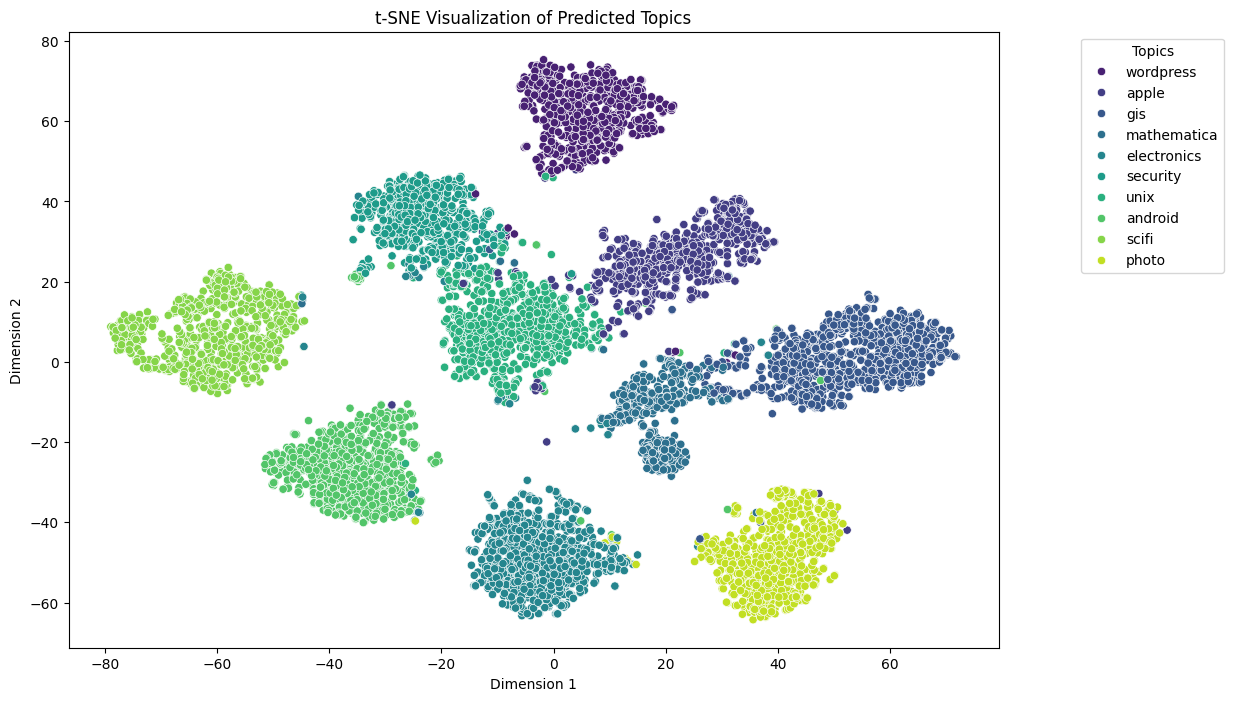

In [ ]:
#Visualize

# Add reduced dimensions to DataFrame
output_data['reduced_x'] = reduced_embeddings[:, 0]
output_data['reduced_y'] = reduced_embeddings[:, 1]

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='reduced_x',
    y='reduced_y',
    hue='topic',
    data=output_data,
    palette='viridis',
    legend='full'
)
plt.title('t-SNE Visualization of Predicted Topics')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), title='Topics')
plt.show()


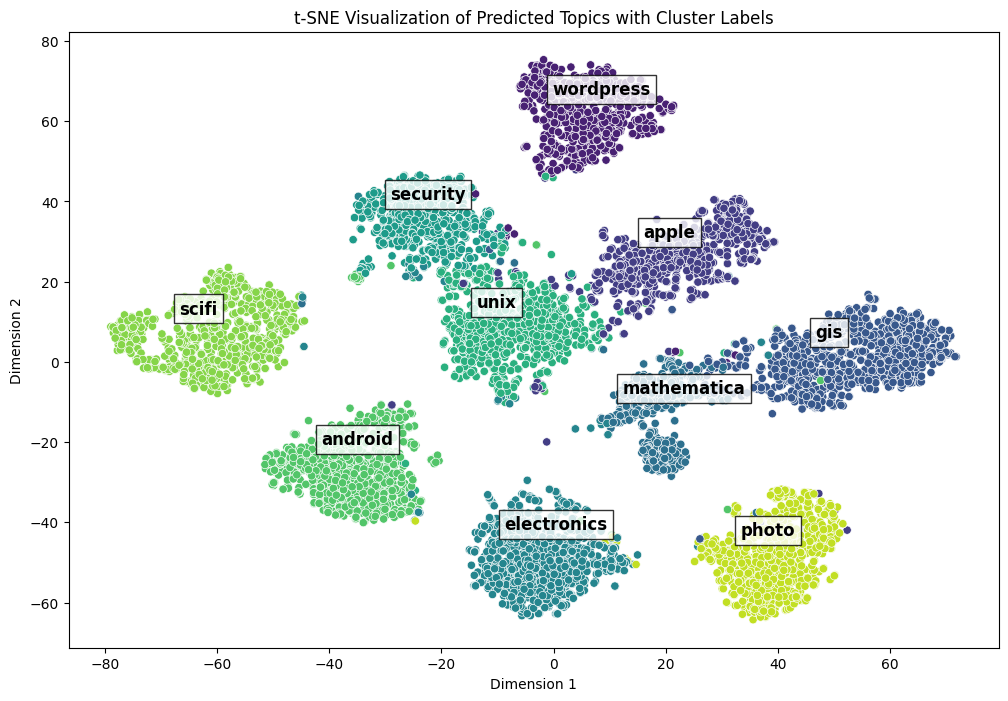

In [ ]:
# Visualize the clusters with label on the cluster

# Compute cluster centers
cluster_centers = output_data.groupby('topic')[['reduced_x', 'reduced_y']].mean()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='reduced_x',
    y='reduced_y',
    hue='topic',
    data=output_data,
    palette='viridis',
    legend=False  # Disable the default legend
)

# Add labels dynamically
texts = []
for topic, row in cluster_centers.iterrows():
    plt.text(
        row['reduced_x'] - 6,  # Adjust offset for x
        row['reduced_y'] + 5,  # Adjust offset for y
        topic,
        fontsize=12,
        weight='bold',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

plt.title('t-SNE Visualization of Predicted Topics with Cluster Labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
# Check the updated DataFrame
output_data.head()


,topic,question,excerpt,reduced_x,reduced_y
0,wordpress,AJAX - Returning Two JSON Objects with One PHP...,How would I go about returning two JSON object...,-2.590890,48.547886
1,apple,Custom highlighting for gtksourceview not working,I am trying to write my own syntax highlightin...,3.990577,47.879459
2,wordpress,plugin class inheritance. cannot change variable,I guess I have a problem understanding inherit...,6.050021,58.963806
3,gis,Is there a max limit for objects per process? ...,"In C++, map class is very comfortable. Instead...",50.436954,-0.769309
4,mathematica,How to change BarChart labels font?,"The question seems trivial, but no sign of suc...",22.970217,-7.157895


In [ ]:
# Qualtify outliers
from scipy.spatial.distance import cdist

# Compute cluster centers
cluster_centers = output_data.groupby('topic')[['reduced_x', 'reduced_y']].mean()

# Calculate distances from cluster centers
distances = cdist(output_data[['reduced_x', 'reduced_y']], cluster_centers, metric='euclidean')

# Find the closest cluster for each point
closest_cluster = distances.argmin(axis=1)
output_data['distance_to_center'] = distances.min(axis=1)

# Define a threshold for outliers (e.g., points farthest from their centers)
threshold = output_data['distance_to_center'].quantile(0.99)  # Top 1% as outliers
outliers = output_data[output_data['distance_to_center'] > threshold]


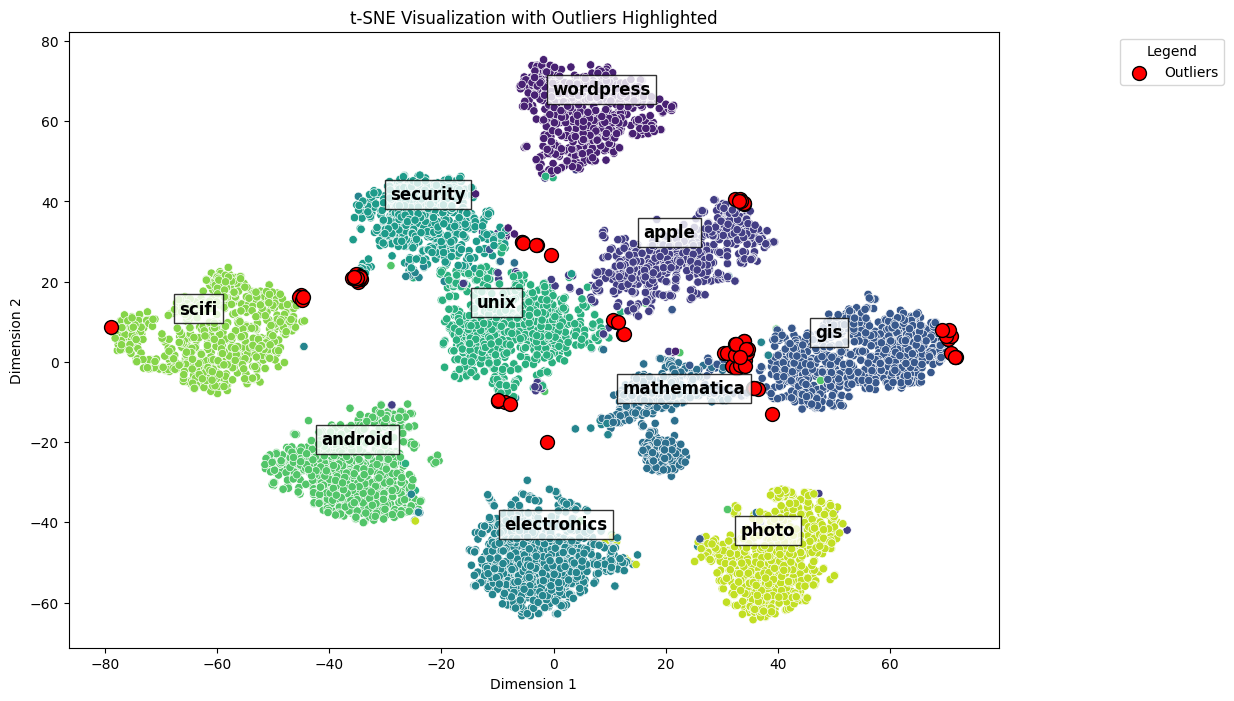

In [ ]:
# Plot clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='reduced_x',
    y='reduced_y',
    hue='topic',
    data=output_data,
    palette='viridis',
    legend=False
)

# Highlight outliers
plt.scatter(
    outliers['reduced_x'],
    outliers['reduced_y'],
    color='red',
    label='Outliers',
    edgecolor='black',
    s=100
)

# Add cluster labels
for topic, row in cluster_centers.iterrows():
    plt.text(
        row['reduced_x']-6,
        row['reduced_y']+5,
        topic,
        fontsize=12,
        weight='bold',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

plt.title('t-SNE Visualization with Outliers Highlighted')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), title='Legend')
plt.show()

In [ ]:
# View outlier details
print(outliers[['topic', 'question', 'excerpt', 'distance_to_center']])

# Save outliers for further analysis
outliers.to_csv("outliers.csv", index=False)

            topic                                           question  \
99          scifi  Incongruous cover art for Phule's Paradise by ...   
326       android         Best way to secure Wi-Fi Direct connection   
368         apple  Which website provide iOS games download stati...   
388           gis         rooftops solar potential - solar radiation   
469           gis  How can I change SQL query through a layer of ...   
...           ...                                                ...   
6904          gis  What functionality exists to calculate Cut and...   
7523  electronics                 How to ANDed bitwise in assembler?   
7704      android                            Heyzap ads in every app   
7741  electronics  What does it mean by “switch” in these context...   
8087        apple  Is it possible to change recorded keynote timi...   

                                                excerpt  distance_to_center  
99    I am rereading the Phule's Company series by R...  

In [ ]:
# Count total documents for each topic in the full dataset
total_counts = output_data['topic'].value_counts()

# Count the outliers for each topic
outlier_counts = outliers['topic'].value_counts()

# Calculate the percentage of outliers
outlier_percentages = (outlier_counts / total_counts * 100).fillna(0)

# Convert to DataFrame for better readability
outlier_summary = pd.DataFrame({
    'Total Documents': total_counts,
    'Outliers': outlier_counts,
    'Outlier Percentage (%)': outlier_percentages
}).sort_values(by='Outlier Percentage (%)', ascending=False)


outlier_summary


,Total Documents,Outliers,Outlier Percentage (%)
topic,,,
gis,988,36.0,3.643725
android,879,15.0,1.706485
apple,768,11.0,1.432292
unix,859,6.0,0.698487
mathematica,494,3.0,0.607287
electronics,908,4.0,0.440529
scifi,915,3.0,0.327869
wordpress,766,2.0,0.261097
security,676,1.0,0.147929
